# Data Cleaning & Preparation

This notebook documents how the raw Energinet balancing dataset was transformed
into an analysis-ready format for DK2.

## 1. Load Raw CSV
- Read **Balancing_Price_Hourly.csv** using `dtype=str` to preserve the original
  string formatting of numeric fields that contained multiple commas
  (e.g. `253,970,001`).

## 2. Rename Verbose Headers
- Original headers contained repeated names and IDs, e.g.  
  `ImbalancePriceDKK | ImbalancePriceDKK | 804717`.
- Renamed to concise column names:
  - `PriceArea`
  - `ImbalancePriceDKK`
  - `ImbalanceMWh`
  - `BalancingPowerPriceUpDKK`
  - `BalancingPowerPriceDownDKK`

## 3. Filter for DK2 Zone
- Kept only rows where `PriceArea` equals **"DK2"** to focus on the DK2 bidding
  zone.

## 4. Clean Numeric Columns
- Many numeric fields used **two commas** where:
  - the **first comma** represented a decimal separator, and
  - the **second comma** was an unwanted thousands separator.
- Implemented a `clean_number` function to:
  1. Split the value on commas,
  2. Keep only the first two parts  
     (e.g. `'253','970','001'` → `'253.970'`),
  3. Convert to a float (`253.97`).
- Applied to:
  - `ImbalancePriceDKK`
  - `ImbalanceMWh`
  - `BalancingPowerPriceUpDKK`
  - `BalancingPowerPriceDownDKK`

## 5. Datetime Handling
- Converted the `ts` column to pandas `datetime` and sorted chronologically.

## 6. Export Cleaned Dataset
- Saved the final, DK2-only, numeric-ready dataset as  
  **`Balancing_Price_Hourly_DK2_clean.csv`** for downstream analysis and plotting.

In [4]:
import pandas as pd

# 1. Load CSV as strings
df = pd.read_csv("Balancing_Price_Hourly.csv", dtype=str)

# 2. Rename messy headers to simple ones
df = df.rename(columns={
    "PriceArea | PriceArea | 804696": "PriceArea",
    "ImbalancePriceDKK | ImbalancePriceDKK | 804717": "ImbalancePriceDKK",
    "ImbalanceMWh | ImbalanceMWh | 804715": "ImbalanceMWh",
    "BalancingPowerPriceUpDKK | BalancingPowerPriceUpDKK | 804719": "BalancingPowerPriceUpDKK",
    "BalancingPowerPriceDownDKK | BalancingPowerPriceDownDKK | 804721": "BalancingPowerPriceDownDKK"
})

# 3. Filter to DK2 only
df = df[df["PriceArea"].str.strip() == "DK2"].copy()

# 4. Generic cleaner: keep only first two comma-separated parts
def clean_number(x):
    if pd.isna(x):
        return None
    parts = x.split(',')
    if len(parts) >= 2:
        return float(parts[0] + '.' + parts[1])
    return float(x.replace(',', '.'))

# 5. Apply cleaner to every numeric column we need
cols_to_clean = [
    "ImbalancePriceDKK",
    "ImbalanceMWh",
    "BalancingPowerPriceUpDKK",
    "BalancingPowerPriceDownDKK"
]
for c in cols_to_clean:
    df[c] = df[c].apply(clean_number)

# 6. Inspect the result
print(df.head())
print(df[cols_to_clean].dtypes)

# 7. Save if desired
df.to_csv("Balancing_Price_Hourly_DK2_clean.csv", index=False)


                    ts PriceArea  ImbalanceMWh  ImbalancePriceDKK  \
0  2020-01-01 00:00:00       DK2           NaN         253.970001   
2  2020-01-01 01:00:00       DK2           NaN         253.970001   
4  2020-01-01 02:00:00       DK2           NaN         253.970001   
6  2020-01-01 03:00:00       DK2           NaN         194.210007   
8  2020-01-01 04:00:00       DK2           NaN         186.740005   

   BalancingPowerPriceUpDKK  BalancingPowerPriceDownDKK  
0                253.970001                  237.330002  
2                253.970001                  235.830002  
4                253.970001                  233.660004  
6                230.449997                  194.210007  
8                225.149994                  186.740005  
ImbalancePriceDKK             float64
ImbalanceMWh                  float64
BalancingPowerPriceUpDKK      float64
BalancingPowerPriceDownDKK    float64
dtype: object


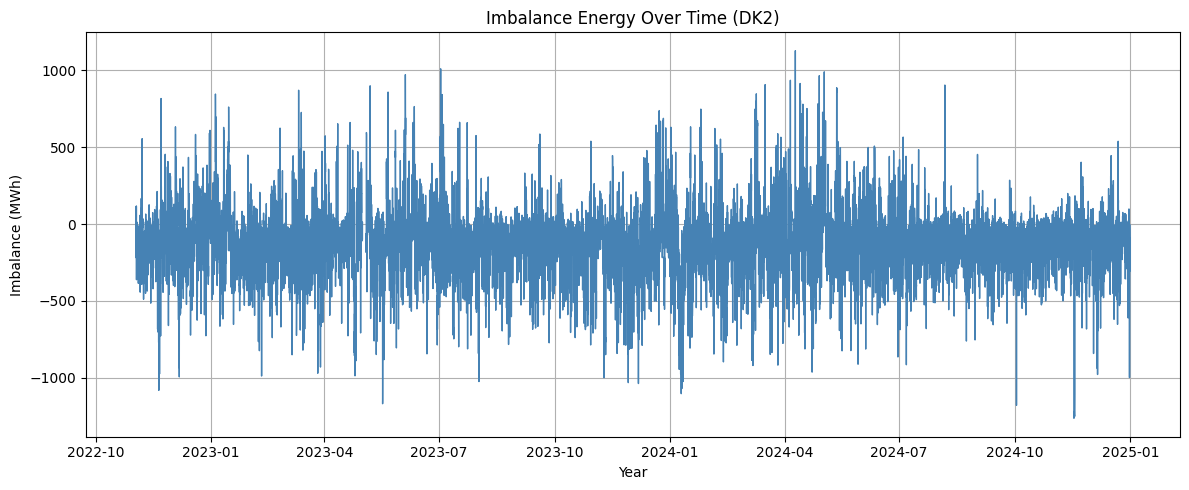

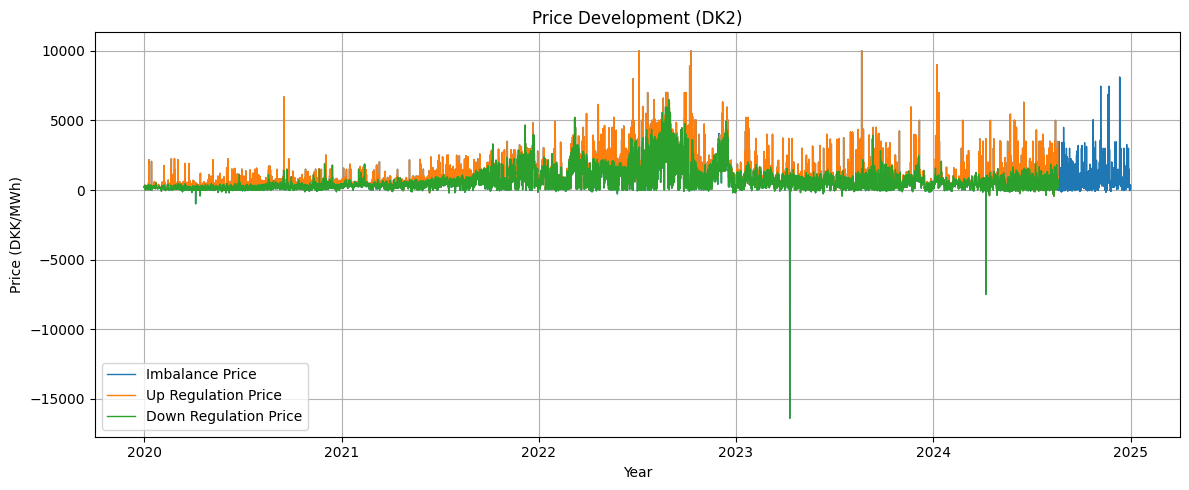

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load the cleaned data ---
df = pd.read_csv("Balancing_Price_Hourly_DK2_clean.csv")

# --- Ensure timestamp is datetime ---
df['ts'] = pd.to_datetime(df['ts'])

# --- Sort by time just in case ---
df = df.sort_values('ts')

# -------- Plot 1: Imbalance in MWh over time --------
plt.figure(figsize=(12, 5))
plt.plot(df['ts'], df['ImbalanceMWh'], color='steelblue', linewidth=1)
plt.title('Imbalance Energy Over Time (DK2)')
plt.xlabel('Year')
plt.ylabel('Imbalance (MWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

# -------- Plot 2: Prices over time --------
plt.figure(figsize=(12, 5))
plt.plot(df['ts'], df['ImbalancePriceDKK'], label='Imbalance Price', linewidth=1)
plt.plot(df['ts'], df['BalancingPowerPriceUpDKK'], label='Up Regulation Price', linewidth=1)
plt.plot(df['ts'], df['BalancingPowerPriceDownDKK'], label='Down Regulation Price', linewidth=1)
plt.title('Price Development (DK2)')
plt.xlabel('Year')
plt.ylabel('Price (DKK/MWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
